# Deconvolution

In [1]:
import itertools
import scanpy as sc
import anndata
import numpy as np
import pandas as pd
import importlib
import scipy as sci
import seaborn as sns
import statannot

import datetime
import autogenes as ag
import matplotlib.pyplot as plt
import matplotlib as mpl
import sklearn
import statsmodels.stats.multitest

In [2]:
mpl.font_manager.fontManager.addfont("../arial.ttf")
mpl.font_manager.fontManager.addfont("../Arial Italic.ttf")
mpl.font_manager.fontManager.addfont("../arialbd.ttf")

In [3]:
mpl.rcParams["figure.figsize"] = (16, 12)
mpl.rcParams["font.family"] = "Arial"
mpl.rcParams['pdf.fonttype'] = 42

Just table of Ensembl gene ids to gene sympols, we'll need it later

In [4]:
genes = pd.read_table("../data/03raw-data/Sample_1/outs/raw_feature_bc_matrix/features.tsv.gz", header=None)

In [5]:
genes = genes.loc[genes[0].str.startswith("GRCh38"), :]

In [6]:
genes[0] = genes[0].str.replace("^GRCh38_+", "")
genes[1] = genes[1].str.replace("^GRCh38_+", "")

In [7]:
genes = genes.loc[~genes[1].duplicated(), :]

In [8]:
genes = genes.set_index(1)

In [9]:
genes

,0,2
1,,
MIR1302-2HG,ENSG00000243485,Gene Expression
FAM138A,ENSG00000237613,Gene Expression
OR4F5,ENSG00000186092,Gene Expression
AL627309.1,ENSG00000238009,Gene Expression
AL627309.3,ENSG00000239945,Gene Expression
...,...,...
AC233755.2,ENSG00000277856,Gene Expression
AC233755.1,ENSG00000275063,Gene Expression
AC240274.1,ENSG00000271254,Gene Expression


## Load data

In [13]:
ds = sc.read_h5ad("../data/02preprint/10obj-named.h5ad")

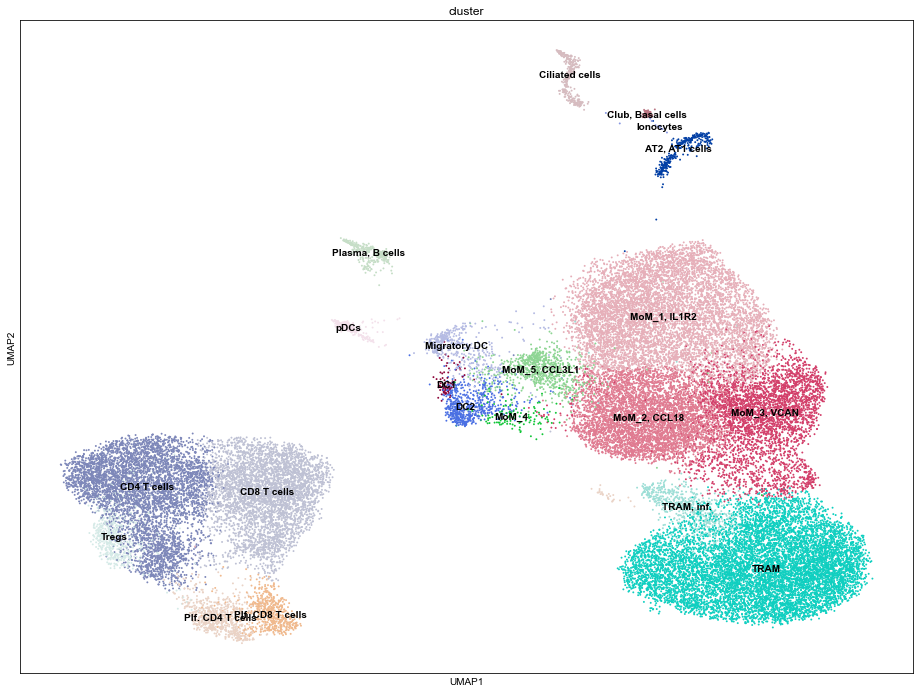

In [14]:
sc.pl.umap(ds, color="cluster", size=15, legend_loc="on data")

Get raw (not scaled) counts

In [15]:
ds_raw = ds.raw.to_adata()

Reverse log-transform, to get just normalized gene counts (to 10k/cell)

In [16]:
ds_raw.X = np.expm1(ds_raw.X)

Name genes with Ensembl id (to make compatible with bulk data)

In [17]:
ds_raw.var_names = genes[0][ds_raw.var_names]

Not all genes survive this transformation

In [18]:
ds_raw = ds_raw[:, ~ds_raw.var_names.isna()].copy()

Bulk counts exported from Rogan's SCRIPT bulk RNAseq data

In [12]:
abulks = sc.read_text("../data/04dataset/01bulk-counts.tsv", first_column_names=True).T
sc.pp.filter_genes(abulks, min_cells=1)

In [13]:
bulk_meta = pd.read_csv("../data/04dataset/01main-meta.csv", index_col=0)
abulks.obs["Diagnosis"] = bulk_meta.Diagnosis
abulks.obs["percent_total_CD206_high"] = bulk_meta.percent_total_CD206_high
abulks.obs["sars_cov2_detected"] = bulk_meta.sars_cov2_detected

In [14]:
for i in range(len(abulks.obs_names)):
    j = bulk_meta.index.get_loc(abulks.obs_names[i])
    if i != j:
        print(i)

In [22]:
ds_raw.shape

(39331, 20099)

In [23]:
sc.pp.filter_genes(ds_raw, min_cells=20)
ds_raw.n_vars

16959

In [24]:
sc.pp.normalize_per_cell(abulks, counts_per_cell_after=1e4, copy=False)

In [25]:
np.intersect1d(ds_raw.var_names, abulks.var_names).size - ds_raw.n_vars

-675

In [26]:
ds_raw = ds_raw[:, np.intersect1d(ds_raw.var_names, abulks.var_names)]
abulks = abulks[:, np.intersect1d(ds_raw.var_names, abulks.var_names)]

In [27]:
ds_raw_log = sc.pp.log1p(ds_raw, copy=True)

Compute 5000 HVGs in log-space, take the normalized counts for them

In [28]:
n_top_genes = 5000
sc.pp.highly_variable_genes(ds_raw_log, flavor='seurat', n_top_genes=n_top_genes, batch_key="orig.ident")

In [29]:
ds_raw_hv = ds_raw[:, ds_raw_log.var['highly_variable']].copy()

In [30]:
ds_raw_hv.shape

(39331, 5000)

In [31]:
set(ds_raw_hv.obs["cluster"])

{'AT2, AT1 cells',
 'CD4 T cells',
 'CD8 T cells',
 'Ciliated cells',
 'Club, Basal cells',
 'DC1',
 'DC2',
 'Ionocytes',
 'Migratory DC',
 'MoM_1, IL1R2',
 'MoM_2, CCL18',
 'MoM_3, VCAN',
 'MoM_4',
 'MoM_5, CCL3L1',
 'Plasma, B cells',
 'Plf. CD4 T cells',
 'Plf. CD8 T cells',
 'TRAM',
 'TRAM, inf.',
 'Tregs',
 'pDCs'}

In [32]:
ds_raw_hv.X = ds_raw_hv.X.todense()

In [33]:
ds_raw_hv.obs.cluster = ds_raw_hv.obs.cluster.astype(str)

In [34]:
print(datetime.datetime.now())
time0 = datetime.datetime.now()

ngenes = 200
ngen = 2000
centroids = ag.init(ds_raw_hv, use_highly_variable=False, celltype_key='cluster')
ag.optimize(ngen=ngen, seed=0, nfeatures=ngenes, mode='fixed', verbose=False)

print(datetime.datetime.now() - time0)

2020-11-28 15:04:13.413883
0:18:32.635029


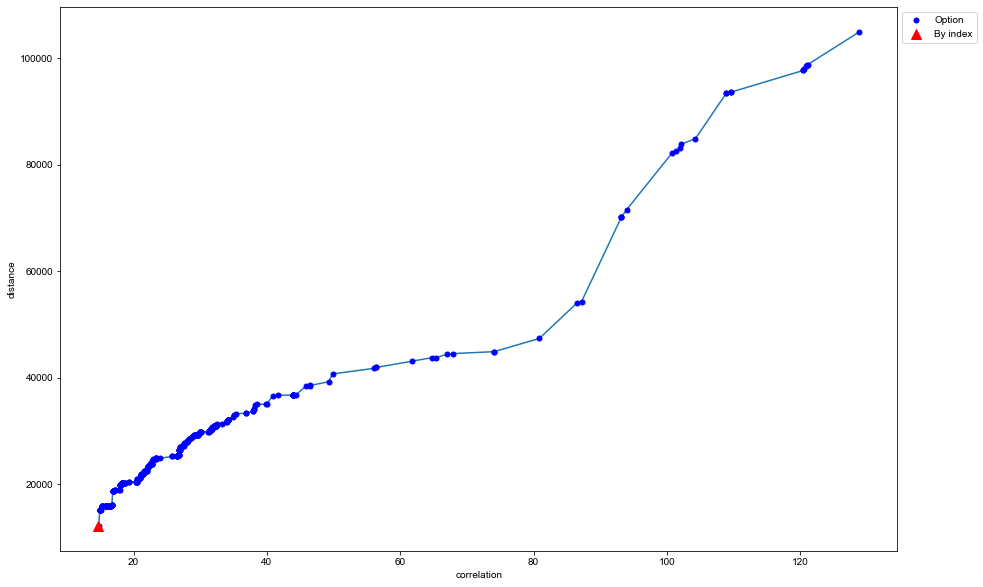

In [36]:
ag.plot(index=0)

In [35]:
ag.fitness_matrix()[0, 0]

14.731626209100227

In [99]:
ag.fitness_matrix()[0, 0]

13.523672632794687

All dots here are solutions to deconvolution problem in the form of a set of 400 genes. Each set has two characteristics: correlation, which we are trying to minimize, and distance, which we are trying to maximize. The higher the correlation, the more mixture between cell types we will have. The lower the distance, the less power to separate cell types. I picked this solution because of low correlation and checked with a graph below.

In [37]:
selection = ag.select(index=0)

centroids_sc_pareto = pd.DataFrame(
    centroids[:,selection].X.T,
    index=centroids[:,selection].var_names,
    columns=centroids[:,selection].obs_names
)

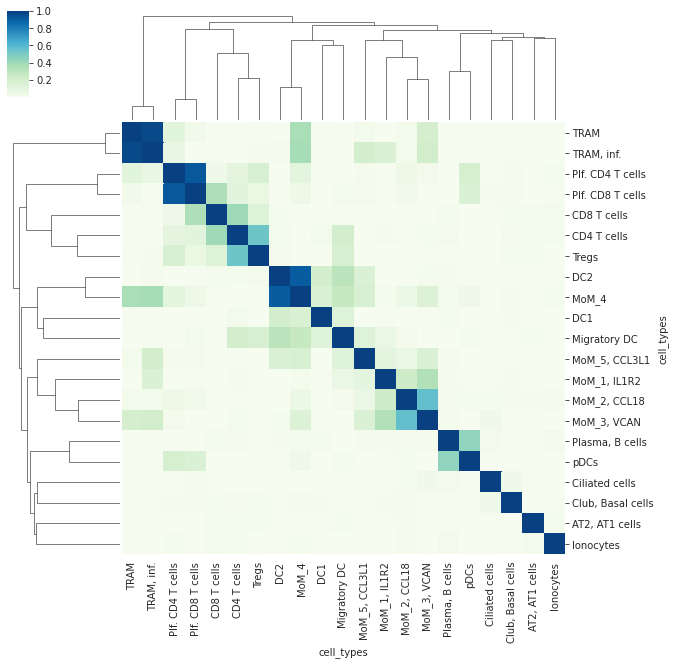

In [101]:
corr = pd.DataFrame(
    data=np.corrcoef(centroids_sc_pareto.T), 
    columns=centroids_sc_pareto.columns, 
    index=centroids_sc_pareto.columns
)
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    sns_plot = sns.clustermap(np.abs(corr), cmap=sns.color_palette("GnBu", 1000), robust=True)

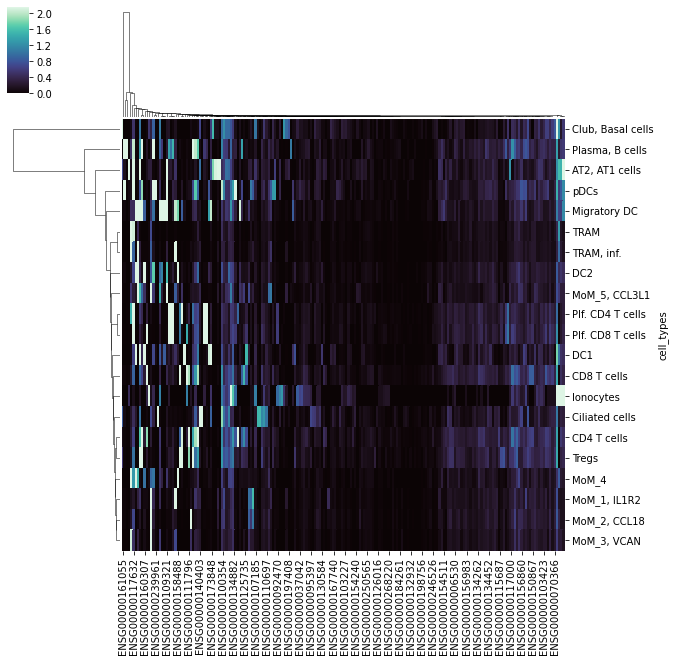

In [102]:
subTypes = pd.Series(centroids_sc_pareto.columns.astype(str))
type_pal = sns.husl_palette(centroids_sc_pareto.columns.size, s=0.7)
lut = dict(zip(centroids_sc_pareto.columns.astype(str).unique().values, type_pal))
row_colors = subTypes.map(lut)
sns_plot = sns.clustermap(centroids_sc_pareto.T, cmap="mako", robust=True) #, cmap="mako", robust=True, row_cluster = False)
#sns_plot.figure.savefig(figdir+"heatmap_GA.png",dpi=300)

Looking at this, let's do this: 
1. merge all T cells
2. merge DC2 and MoM_4
3. merge TRAM and infected TRAM
4. remove Ionocytes, too few of them

And then go select HVG again

In [38]:
ds_raw2 = ds_raw.copy()

In [39]:
ds_raw2.obs.cluster = ds_raw2.obs.cluster.astype(str)

In [40]:
t_cell_cluster = ["CD4 T cells", "Tregs", "CD8 T cells", "Plf. CD4 T cells", "Plf. CD8 T cells"]
ds_raw2.obs.loc[ds_raw2.obs.cluster.isin(t_cell_cluster), "cluster"] = "T cells"

In [41]:
ds_raw2.obs.loc[ds_raw2.obs.cluster == "MoM_4", "cluster"] = "DC2"

In [42]:
ds_raw2.obs.loc[ds_raw2.obs.cluster == "TRAM, inf.", "cluster"] = "TRAM"

In [43]:
ds_raw2 = ds_raw2[ds_raw2.obs.cluster != "MoM_5, CCL3L1", :].copy()

In [44]:
ds_raw2 = ds_raw2[ds_raw2.obs.cluster != "Ionocytes", :].copy()

In [45]:
ds_raw2.shape

(38547, 16284)

In [46]:
ds_raw2_log = sc.pp.log1p(ds_raw2, copy=True)

In [47]:
n_top_genes = 4500
sc.pp.highly_variable_genes(ds_raw2_log, flavor='seurat', n_top_genes=n_top_genes, batch_key="orig.ident")

... storing 'cluster' as categorical


In [48]:
ds_raw2_hv = ds_raw2[:, ds_raw2_log.var['highly_variable']].copy()

In [49]:
ds_raw2_hv.X = ds_raw2_hv.X.todense()

In [50]:
ds_raw2_hv.obs.cluster = ds_raw2_hv.obs.cluster.astype(str)

Retrain

In [51]:
print(datetime.datetime.now())
time0 = datetime.datetime.now()

ngenes = 200
ngen = 2000
centroids = ag.init(ds_raw2_hv, use_highly_variable=False, celltype_key='cluster')
ag.optimize(ngen=ngen, seed=0, nfeatures=ngenes, mode='fixed', verbose=False)

print(datetime.datetime.now() - time0)

2020-11-28 15:26:24.480955
0:08:46.698950


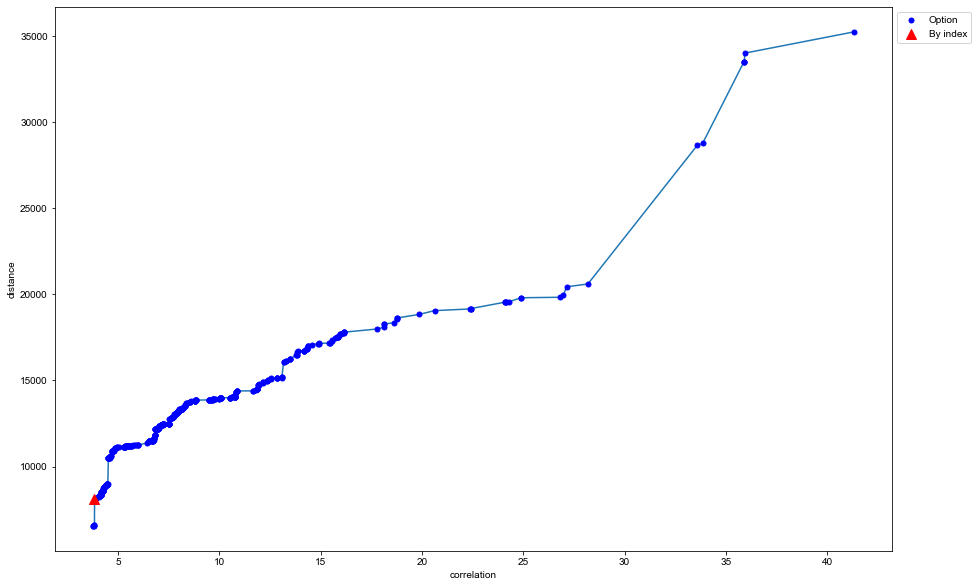

In [52]:
ag.plot(index=5)

In [53]:
selection = ag.select(index=5)

centroids_sc_pareto = pd.DataFrame(
    centroids[:,selection].X.T,
    index=centroids[:,selection].var_names,
    columns=centroids[:,selection].obs_names
)

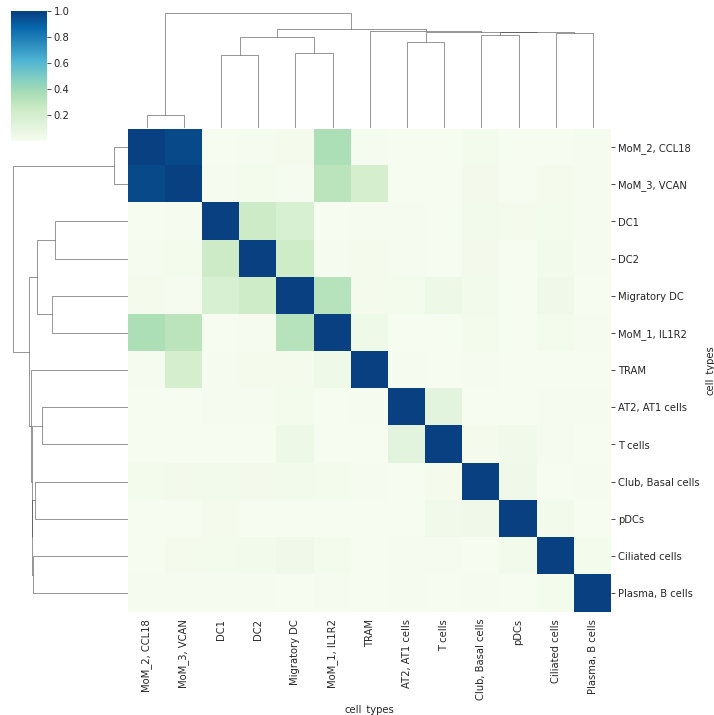

In [54]:
corr = pd.DataFrame(
    data=np.corrcoef(centroids_sc_pareto.T), 
    columns=centroids_sc_pareto.columns, 
    index=centroids_sc_pareto.columns
)
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    sns_plot = sns.clustermap(np.abs(corr), cmap=sns.color_palette("GnBu", 1000), robust=True)

In [55]:
sig_genes = centroids_sc_pareto.loc[:, ["TRAM", "MoM_1, IL1R2", "MoM_2, CCL18", "MoM_3, VCAN"]].copy()

In [56]:
pd.DataFrame(sig_genes).merge(genes, left_index=True, right_on=0).sort_values(
    "MoM_2, CCL18", 
    ascending=False
).head(30)

,TRAM,"MoM_1, IL1R2","MoM_2, CCL18","MoM_3, VCAN",0,2
1,,,,,,
SPP1,0.102796,7.214849,11.918159,10.065861,ENSG00000118785,Gene Expression
STAB1,0.008769,1.578354,3.204430,1.811381,ENSG00000010327,Gene Expression
CCL8,0.072576,16.337446,1.562621,0.617700,ENSG00000108700,Gene Expression
MAF,0.110324,0.313687,1.208619,0.471426,ENSG00000178573,Gene Expression
MYCBP2,0.603811,1.177013,1.048793,0.832087,ENSG00000005810,Gene Expression
KLF2,0.628629,0.838964,0.960188,0.722514,ENSG00000127528,Gene Expression
HIST1H1C,0.282252,0.779351,0.845846,0.984082,ENSG00000187837,Gene Expression
NKTR,0.402806,0.756045,0.813218,0.606078,ENSG00000114857,Gene Expression
MT1X,0.214574,1.209204,0.776712,0.978332,ENSG00000187193,Gene Expression


In [42]:
pd.DataFrame(sig_genes).merge(genes, left_index=True, right_on=0).sort_values(
    "TRAM", 
    ascending=False
).head(30)

,TRAM,"MoM_1, IL1R2","MoM_2, CCL18","MoM_3, VCAN",0,2
1,,,,,,
FABP4,25.001062,0.108391,0.170873,2.109432,ENSG00000170323,Gene Expression
VCAN,0.728339,2.508672,3.691550,11.255027,ENSG00000038427,Gene Expression
EGR1,0.545543,0.157243,0.294938,0.550588,ENSG00000120738,Gene Expression
PTK2B,0.506586,0.976562,0.498886,0.511443,ENSG00000120899,Gene Expression
YPEL3,0.397668,0.349374,0.745671,0.437396,ENSG00000090238,Gene Expression
URI1,0.356205,0.270535,0.428855,0.370187,ENSG00000105176,Gene Expression
GON4L,0.292558,0.576503,0.594596,0.425994,ENSG00000116580,Gene Expression
TAF3,0.272560,0.400471,0.401251,0.374046,ENSG00000165632,Gene Expression
USP34,0.257187,0.386416,0.475051,0.361939,ENSG00000115464,Gene Expression


In [217]:
sns_plot.fig.subplots_adjust(bottom=0.18, right=0.82, top=0.95, left=0.05)

In [218]:
sns_plot.fig.savefig("06deconv-corr.pdf")

Graph of correlation between cell types with a given solution

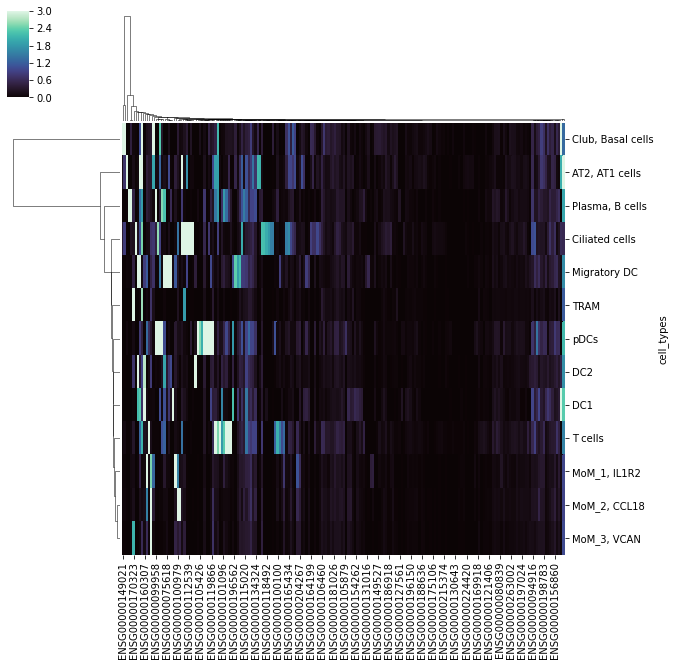

In [219]:
subTypes = pd.Series(centroids_sc_pareto.columns)
type_pal = sns.husl_palette(centroids_sc_pareto.columns.size, s=0.7)
lut = dict(zip(centroids_sc_pareto.columns.unique().values, type_pal))
row_colors = subTypes.map(lut)
sns_plot = sns.clustermap(centroids_sc_pareto.T, cmap="mako", robust=True) #, cmap="mako", robust=True, row_cluster = False)
#sns_plot.figure.savefig(figdir+"heatmap_GA.png",dpi=300)

In [57]:
abulks_hv = abulks[:, ds_raw2_log.var['highly_variable']]

In [58]:
abulks_hv.shape

(232, 4500)

In [59]:
coef_nnls = ag.deconvolve(abulks_hv.X, model='nnls') #model='nusvr'
# coef_nnls = ag.deconvolve(abulks_hv.X, model='nusvr') #model='nusvr'
coef_nnls.shape

(232, 13)

In [60]:
def normalize_proportions(data, copy):
    if copy == True:
        data_copy = data.copy()
    else:
        data_copy = data
    data_copy[data_copy < 0] = 0
    for raw in data_copy.index:
        sum = data_copy.loc[raw].sum()
        if sum != 0:
            data_copy.loc[raw] = np.divide(data_copy.loc[raw], sum)
        else:
            data_copy.loc[raw] = 0
    return data_copy

In [61]:
proportions_nnls = pd.DataFrame(data=coef_nnls.T, index = centroids_sc_pareto.columns, columns = abulks_hv.obs_names)
proportions_nnls_norm = normalize_proportions(proportions_nnls.T,copy=True).T

In [62]:
proportions_nnls_norm = proportions_nnls_norm.set_index(proportions_nnls_norm.index)
proportions_nnls_norm = proportions_nnls_norm.astype(float)

In [63]:
proportions = proportions_nnls_norm.copy()

In [15]:
cols_meta = abulks.obs.loc[:, ["Diagnosis", "percent_total_CD206_high", "sars_cov2_detected"]].copy()
cols = cols_meta.copy()

In [16]:
cols.loc[cols.Diagnosis != "COVID-19", "sars_cov2_detected"] = False

In [17]:
cols.Diagnosis.unique()

array(['Non-Pneumonia Control', 'Other Pneumonia',
       'Other Viral Pneumonia', 'COVID-19', 'Healthy Control'],
      dtype=object)

In [18]:
lut = dict(zip(cols.Diagnosis.unique(), ["#4DBBD5", "#3C5488", "#00A087", "#E64B35", "#8491B4"]))
cols.Diagnosis = cols.Diagnosis.map(lut)

In [19]:
cd206_cols = plt.cm.BuGn(0.3 + 0.7 * cols.percent_total_CD206_high / 100, bytes=True)

In [20]:
cd206_cols = pd.DataFrame(cd206_cols.reshape(232, -1)).apply(lambda x: f"#{x[0]:0>2x}{x[1]:0>2x}{x[2]:0>2x}", axis=1)

In [21]:
cols.percent_total_CD206_high = cd206_cols.values

In [22]:
cols.percent_total_CD206_high[cols.percent_total_CD206_high == "#000000"] = "#7A451E"

/projects/b1038/Pulmonary/nmarkov/script/code/.venv/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [23]:
cols.sars_cov2_detected = cols.sars_cov2_detected.replace({
    False: "#FFFFFF",
    True: (lambda x: f"#{x[0]:0>2x}{x[1]:0>2x}{x[2]:0>2x}")(mpl.cm.tab10(0, bytes=True)),
})

In [24]:
cols.columns = ["Diagnosis", "% CD206 high", "SARS-CoV-2 detected"]

In [24]:
proportions

,300291725_SCRIPT_RNAseq_Batch_01,300306779_SCRIPT_RNAseq_Batch_02,300306794_SCRIPT_RNAseq_Batch_01,300311424_SCRIPT_RNAseq_Batch_02,300311432_SCRIPT_RNAseq_Batch_01,300311436_SCRIPT_RNAseq_Batch_01,300311440_SCRIPT_RNAseq_Batch_01,300311456_SCRIPT_RNAseq_Batch_02,300311466_SCRIPT_RNAseq_Batch_01,300311483_SCRIPT_RNAseq_Batch_02,...,368523523_SCRIPT_RNAseq_Batch_11,368523734_SCRIPT_RNAseq_Batch_11,368524206_SCRIPT_RNAseq_Batch_10,368524210_SCRIPT_RNAseq_Batch_11,368524237_SCRIPT_RNAseq_Batch_10,368524239_SCRIPT_RNAseq_Batch_10,368524253_SCRIPT_RNAseq_Batch_11,368524275_SCRIPT_RNAseq_Batch_11,368525513_SCRIPT_RNAseq_Batch_11,368525517_SCRIPT_RNAseq_Batch_10
cell_types,,,,,,,,,,,,,,,,,,,,,
"AT2, AT1 cells",0.0,0.001325,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.008844,0.0,...,0.0,0.000000,0.001120,0.000789,0.001013,0.000000,0.000000,0.001835,0.000180,0.000000
Ciliated cells,0.0,0.000000,0.000000,0.001749,0.000123,0.000000,0.000000,0.000000,0.000099,0.0,...,0.0,0.001964,0.000000,0.001544,0.000000,0.000828,0.010951,0.002225,0.005447,0.000000
"Club, Basal cells",0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.000000,0.000182,0.000000,0.000163,0.000000,0.000000,0.000000,0.000000,0.000000
DC1,0.0,0.007652,0.009813,0.009531,0.016654,0.004180,0.017976,0.000577,0.037431,0.0,...,0.0,0.042277,0.010857,0.029819,0.008399,0.024948,0.091096,0.039480,0.048761,0.000000
DC2,0.0,0.017601,0.000000,0.000000,0.000000,0.000000,0.000330,0.000000,0.182294,0.0,...,0.0,0.006734,0.021542,0.041445,0.014090,0.015395,0.073709,0.016294,0.056186,0.000000
Migratory DC,0.0,0.060303,0.001887,0.000687,0.000404,0.009391,0.000000,0.002900,0.010836,0.0,...,0.0,0.000000,0.000000,0.018630,0.000000,0.003723,0.001427,0.001581,0.001699,0.000000
"MoM_1, IL1R2",0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
"MoM_2, CCL18",0.0,0.000000,0.000000,0.000000,0.064548,0.024619,0.000000,0.000000,0.090969,0.0,...,0.0,0.114128,0.000000,0.142301,0.012486,0.061515,0.032935,0.057897,0.000000,0.141784
"MoM_3, VCAN",1.0,0.913119,0.988299,0.277749,0.913057,0.961810,0.979141,0.996523,0.587980,1.0,...,1.0,0.821800,0.966298,0.765472,0.963848,0.891395,0.750241,0.868294,0.843318,0.858216


Save proportions to not recompute each time.

In [74]:
proportions.to_csv("11proportions_v2.csv")

In [10]:
proportions = pd.read_csv("11proportions_v2.csv", index_col=0)
proportions

,S_300291725,S_300306779,S_300306794,S_300311424,S_300311432,S_300311436,S_300311440,S_300311456,S_300311466,S_300311483,...,S_368523515,S_368523523,S_368523734,S_368524206,S_368524210,S_368524239,S_368524253,S_368524275,S_368525513,S_368525517
cell_types,,,,,,,,,,,,,,,,,,,,,
"AT2, AT1 cells",0.001078,0.000000,0.000178,0.000000,0.004602,0.00000,0.006332,0.000000,0.003183,0.000892,...,0.000000,0.000000,0.003761,0.002179,0.000918,0.000000,0.003341,0.000149,0.000945,0.004508
Ciliated cells,0.003460,0.000000,0.000000,0.000000,0.011395,0.00000,0.023906,0.000000,0.000135,0.001580,...,0.006288,0.000000,0.046035,0.004160,0.005370,0.001100,0.027980,0.000000,0.020750,0.015201
"Club, Basal cells",0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000081,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000156,0.000969,0.000000,0.000000,0.000244,0.000000,0.000000,0.000309
DC1,0.020067,0.000000,0.015130,0.009844,0.038421,0.00000,0.086966,0.000000,0.028612,0.043732,...,0.030900,0.000000,0.145668,0.055654,0.025968,0.018173,0.111221,0.000158,0.092388,0.037948
DC2,0.022840,0.000000,0.005460,0.002513,0.014872,0.00000,0.033444,0.000000,0.012885,0.030105,...,0.008297,0.000000,0.043891,0.022214,0.013726,0.005439,0.035072,0.000000,0.025858,0.024841
Migratory DC,0.000000,0.019534,0.002124,0.000000,0.000000,0.00000,0.026361,0.000000,0.008744,0.000000,...,0.000000,0.000000,0.006188,0.000000,0.014514,0.000000,0.000000,0.000000,0.000000,0.007172
"MoM_1, IL1R2",0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.143950,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.046480,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
"MoM_2, CCL18",0.926401,0.741957,0.118911,0.001889,0.510920,0.57113,0.420940,0.416973,0.655953,0.709081,...,0.319445,0.527384,0.409244,0.748144,0.931583,0.270270,0.472301,0.388258,0.534373,0.820173
"MoM_3, VCAN",0.000000,0.238338,0.840604,0.000000,0.320485,0.42887,0.000000,0.583027,0.000000,0.000000,...,0.522246,0.472616,0.000000,0.000000,0.000000,0.690423,0.000000,0.610697,0.000000,0.000000


In [59]:
proportions.loc[:, abulks.obs.Diagnosis == "Healthy Control"]

,340201217_SCRIPT_RNAseq_Batch_10,340236050_SCRIPT_RNAseq_Batch_10,340236058_SCRIPT_RNAseq_Batch_10,340236729_SCRIPT_RNAseq_Batch_10,340239828_SCRIPT_RNAseq_Batch_10
cell_types,,,,,
"AT2, AT1 cells",0.000307,0.000000,0.000322,0.000000,0.000279
Ciliated cells,0.006202,0.017316,0.007396,0.004777,0.004570
"Club, Basal cells",0.000004,0.000018,0.000000,0.000338,0.000000
DC1,0.080176,0.094918,0.042707,0.069231,0.026227
DC2,0.078994,0.085542,0.051221,0.062847,0.037622
Migratory DC,0.003528,0.009061,0.002746,0.003427,0.003950
"MoM_1, IL1R2",0.000000,0.011596,0.000000,0.000000,0.000000
"MoM_2, CCL18",0.050644,0.075874,0.341162,0.084693,0.027515
"MoM_3, VCAN",0.282868,0.034635,0.000000,0.140453,0.464380


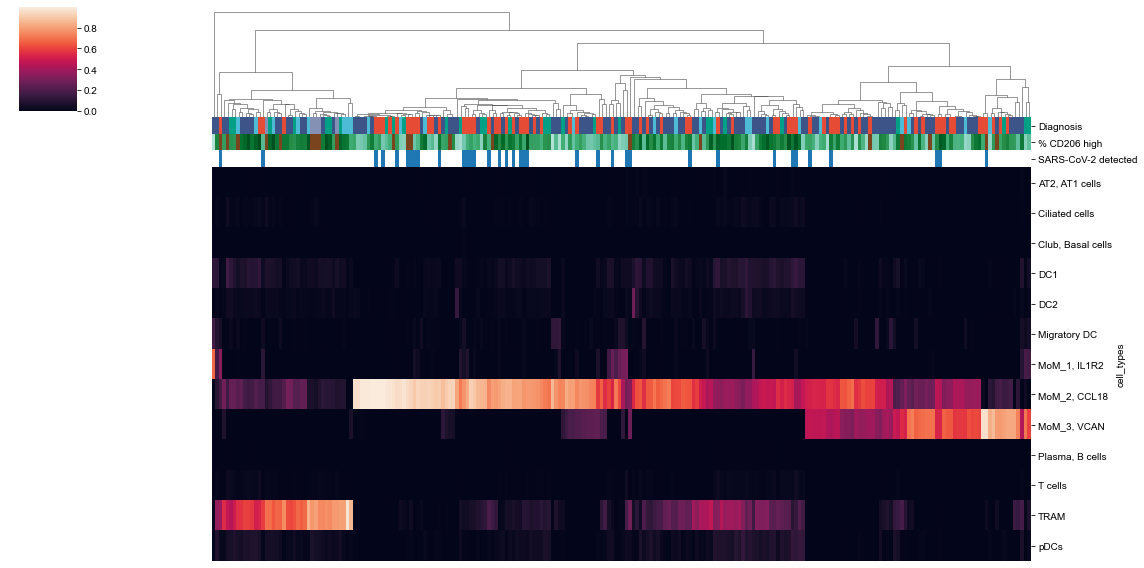

In [25]:
ax = sns.clustermap(
    proportions, 
    col_cluster=True, 
    row_cluster=False, 
    xticklabels=False, 
    figsize=(16, 8),
    col_colors=cols,
    linecolor="none",
    snap=True
)

In [27]:
clusters = pd.Series(proportions.index.astype(str))
clusters = clusters[clusters.str.match("^MoM|TRAM")]

proportions3 = proportions.loc[clusters, :]

In [29]:
hue_order = ["Healthy Control", "Non-Pneumonia Control", "COVID-19", "Other Viral Pneumonia", "Other Pneumonia"]
hue_map = {x: i for i, x in enumerate(hue_order)}
cols_meta["diagnosis_order"] = cols_meta.Diagnosis.replace(hue_map)
samples_order = cols_meta.sort_values(["diagnosis_order", "percent_total_CD206_high"]).index

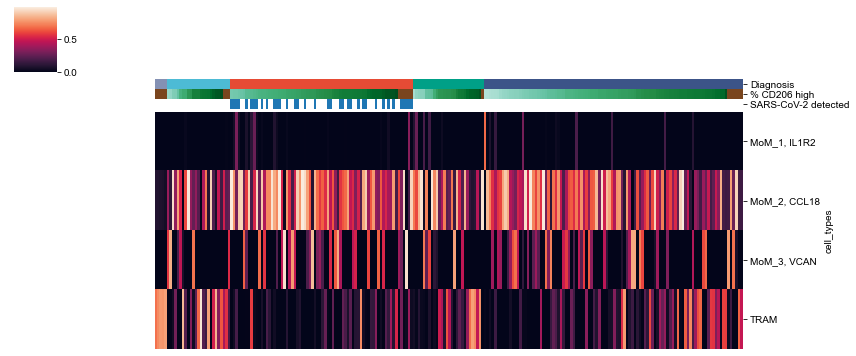

In [78]:
ax = sns.clustermap(
    proportions3.loc[:, samples_order], 
    col_cluster=False, 
    row_cluster=False, 
    xticklabels=False, 
    figsize=(12, 5),
    col_colors=cols.loc[samples_order],
    linecolor="face",
    linewidths=0.03,
    snap=True,
    cmap=sns.cm.rocket,
)

In [31]:
ax.fig.subplots_adjust(bottom=0.02, top=0.9, left=-0.15, right=0.83)

ax.fig.axes[-2].collections[-1].colorbar.remove()

for i, x in enumerate(ax.fig.axes):
    pos = x.get_position()
    pos.x0 = 0.18
    pos.x1 = 0.81
    if i == 2:
        pos.y0 = 0.7
        pos.y1 = 0.85
    if i == 3:
        pos.y1 = 0.695
    x.set_position(pos)

labels = list(ax.fig.axes[-1].get_yticklabels())
new_labels = []
for l in labels:
    new_label = l._text.split(",")[0].replace("MoM_", "MoAM")
    if new_label.startswith("MoAM"):
        new_label = new_label[:-1] + str(int(new_label[-1]) + 1)
    new_labels.append(new_label)
ax.fig.axes[-1].tick_params(left=True, right=False, labelleft=True, labelright=False)
ax.fig.axes[-1].set_ylabel("")
ax.fig.axes[-1].set_yticklabels(new_labels, rotation="0", fontdict={"fontsize": 16})
ax.fig.axes[2].tick_params(left=True, right=False, labelleft=True, labelright=False, labelsize=14)

d_cols = ["#8491B4", "#4DBBD5", "#E64B35", "#00A087", "#3C5488"]
handles = []
for i, d in enumerate(hue_order):
    handles.append(mpl.patches.Patch(color=d_cols[i], label=d))
    
ax.fig.legend(
    handles=handles, 
    title="Diagnosis", 
    handlelength=1, 
    frameon=False, 
    title_fontsize=14, 
    fontsize=12,
    loc='upper left', 
    bbox_to_anchor=(0.81, 0.85)
)

In [32]:
class PoorManNormalize(mpl.colors.Normalize):
    def __call__(self, value, clip=None):
        return np.ma.masked_array(value * 0.7 + 0.3)
    
cax = ax.fig.add_axes((0.82, 0.28, 0.02, 0.15))
cax.set_title("% CD206 high", fontdict={"fontsize": 14}, pad=10, loc="left")
ax.fig.colorbar(
    mpl.cm.ScalarMappable(norm=PoorManNormalize(), cmap="BuGn"),
    cax=cax,
    ticks=[0, 0.25, 0.50, 0.75, 1]
)
cax.set_yticklabels([0, 25, 50, 75, 100])

[Text(1, 0, '0'),
 Text(1, 0, '25'),
 Text(1, 0, '50'),
 Text(1, 0, '75'),
 Text(1, 0, '100')]

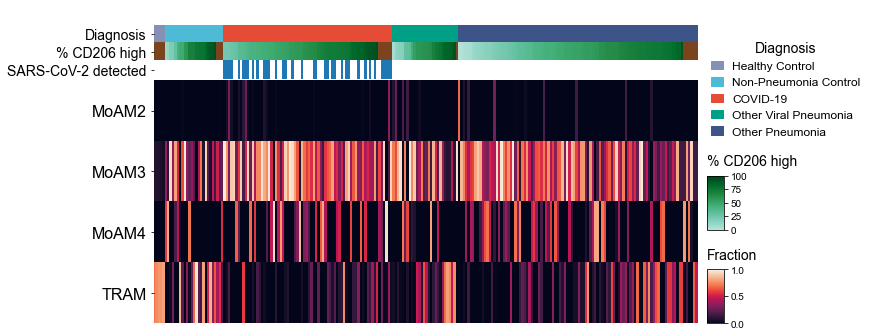

In [33]:
cax = ax.fig.add_axes((0.82, 0.02, 0.02, 0.15))
cax.set_title("Fraction", fontdict={"fontsize": 14}, pad=10, loc="left")
ax.fig.colorbar(
    mpl.cm.ScalarMappable(norm=None, cmap=sns.cm.rocket),
    cax=cax
)
ax.fig

In [82]:
ax.fig.savefig("07plots/S5B_deconv_heatmap_order_v3.pdf")

## Box plots of proportions by diagnosis

In [34]:
props = proportions3.T.copy()
props["Diagnosis"] = abulks.obs.Diagnosis
props

cell_types,"MoM_1, IL1R2","MoM_2, CCL18","MoM_3, VCAN",TRAM,Diagnosis
S_300291725,0.0,0.926401,0.000000,0.002983,Non-Pneumonia Control
S_300306779,0.0,0.741957,0.238338,0.000000,Other Pneumonia
S_300306794,0.0,0.118911,0.840604,0.000000,Non-Pneumonia Control
S_300311424,0.0,0.001889,0.000000,0.979230,Non-Pneumonia Control
S_300311432,0.0,0.510920,0.320485,0.046056,Other Pneumonia
...,...,...,...,...,...
S_368524239,0.0,0.270270,0.690423,0.000000,COVID-19
S_368524253,0.0,0.472301,0.000000,0.229971,COVID-19
S_368524275,0.0,0.388258,0.610697,0.000000,COVID-19
S_368525513,0.0,0.534373,0.000000,0.223749,COVID-19


In [35]:
props = props.melt(value_vars=clusters.values, id_vars="Diagnosis")

In [36]:
props.cell_types.replace({
    "MoM_1, IL1R2": "MoAM2",
    "MoM_2, CCL18": "MoAM3",
    "MoM_3, VCAN":  "MoAM4"
}, inplace=True)
props

,Diagnosis,cell_types,value
0,Non-Pneumonia Control,MoAM2,0.000000
1,Other Pneumonia,MoAM2,0.000000
2,Non-Pneumonia Control,MoAM2,0.000000
3,Non-Pneumonia Control,MoAM2,0.000000
4,Other Pneumonia,MoAM2,0.000000
...,...,...,...
923,COVID-19,TRAM,0.000000
924,COVID-19,TRAM,0.229971
925,COVID-19,TRAM,0.000000
926,COVID-19,TRAM,0.223749


In [37]:
props = props.loc[props.cell_types != "MoAM2", :]

In [38]:
# From https://stackoverflow.com/a/48541304/4317857
def adjust_box_widths(g, fac):
    """
    Adjust the withs of a seaborn-generated boxplot.
    """

    # iterating through Axes instances
    for ax in g.axes:

        # iterating through axes artists:
        for c in ax.get_children():

            # searching for PathPatches
            if isinstance(c, mpl.patches.PathPatch):
                # getting current width of box:
                p = c.get_path()
                verts = p.vertices
                verts_sub = verts[:-1]
                xmin = np.min(verts_sub[:, 0])
                xmax = np.max(verts_sub[:, 0])
                xmid = 0.5*(xmin+xmax)
                xhalf = 0.5*(xmax - xmin)

                # setting new width of box
                xmin_new = xmid-fac*xhalf
                xmax_new = xmid+fac*xhalf
                verts_sub[verts_sub[:, 0] == xmin, 0] = xmin_new
                verts_sub[verts_sub[:, 0] == xmax, 0] = xmax_new

                # setting new width of median line
                for l in ax.lines:
                    if np.all(l.get_xdata() == [xmin, xmax]):
                        l.set_xdata([xmin_new, xmax_new])

In [39]:
ccc = ["#8491B4", "#4DBBD5", "#E64B35", "#00A087", "#3C5488"]

Normal distribution?

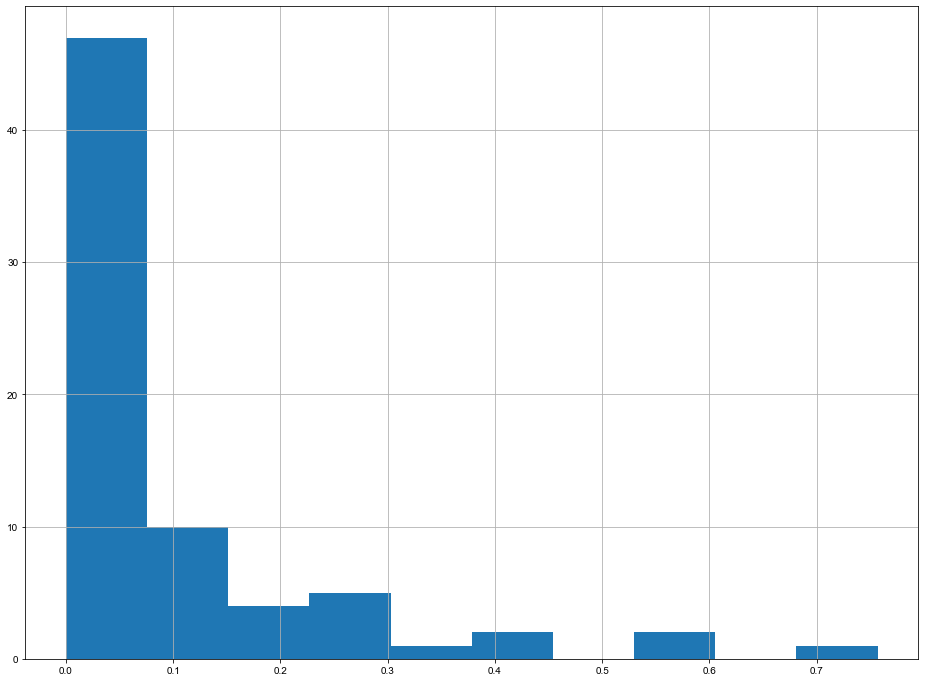

In [138]:
props.value[(props.cell_types == "TRAM") & (props.Diagnosis == "COVID-19")].hist()

Not normal

In [40]:
rows = []
for cell_type in props.cell_types.unique():
    for d0, d1 in itertools.combinations(props.Diagnosis.unique(), 2):
        idx0 = (props.cell_types == cell_type) & (props.Diagnosis == d0)
        idx1 = (props.cell_types == cell_type) & (props.Diagnosis == d1)
        _, pval = sci.stats.mannwhitneyu(props.value[idx0], props.value[idx1])
        row = [cell_type, d0, d1, pval]
        rows.append(row)
        if pval < 0.05:
            print(f"{cell_type}: {d0} vs {d1}: p-value {pval}")

MoAM3: Non-Pneumonia Control vs Other Pneumonia: p-value 0.02473216774009622
MoAM3: Non-Pneumonia Control vs COVID-19: p-value 0.001997774394096427
MoAM3: Non-Pneumonia Control vs Healthy Control: p-value 0.004455010794432807
MoAM3: Other Pneumonia vs COVID-19: p-value 0.017897367582804007
MoAM3: Other Pneumonia vs Healthy Control: p-value 0.00020379959674485574
MoAM3: Other Viral Pneumonia vs Healthy Control: p-value 0.0019443339584973229
MoAM3: COVID-19 vs Healthy Control: p-value 0.00022917881282193966
MoAM4: Other Pneumonia vs Other Viral Pneumonia: p-value 0.04626891083092173
MoAM4: Other Pneumonia vs Healthy Control: p-value 0.03273981106749791
MoAM4: COVID-19 vs Healthy Control: p-value 0.047706404805078005
TRAM: Non-Pneumonia Control vs Other Pneumonia: p-value 0.010761388976965013
TRAM: Non-Pneumonia Control vs COVID-19: p-value 0.0003687360774519195
TRAM: Non-Pneumonia Control vs Healthy Control: p-value 0.0082371688643391
TRAM: Other Pneumonia vs Other Viral Pneumonia: p-val

In [41]:
pvals = pd.DataFrame(rows, columns=["Cell type", "Pair 1", "Pair 2", "p-value"])

In [43]:
_, padj = statsmodels.stats.multitest.fdrcorrection(pvals["p-value"])

In [44]:
pvals["adj. p-value"] = padj
pvals

,Cell type,Pair 1,Pair 2,p-value,adj. p-value
0,MoAM3,Non-Pneumonia Control,Other Pneumonia,0.024732,0.052998
1,MoAM3,Non-Pneumonia Control,Other Viral Pneumonia,0.150701,0.180841
2,MoAM3,Non-Pneumonia Control,COVID-19,0.001998,0.006659
3,MoAM3,Non-Pneumonia Control,Healthy Control,0.004455,0.013365
4,MoAM3,Other Pneumonia,Other Viral Pneumonia,0.397232,0.418661
5,MoAM3,Other Pneumonia,COVID-19,0.017897,0.041302
6,MoAM3,Other Pneumonia,Healthy Control,0.000204,0.001719
7,MoAM3,Other Viral Pneumonia,COVID-19,0.089562,0.127946
8,MoAM3,Other Viral Pneumonia,Healthy Control,0.001944,0.006659
9,MoAM3,COVID-19,Healthy Control,0.000229,0.001719


In [45]:
pvals = pvals.loc[pvals["Cell type"] != "MoAM2", :]

In [46]:
pairs = pvals.loc[pvals["adj. p-value"] < 0.05, :].apply(lambda x: ((x[0], x[1]), (x[0], x[2])), axis=1).values

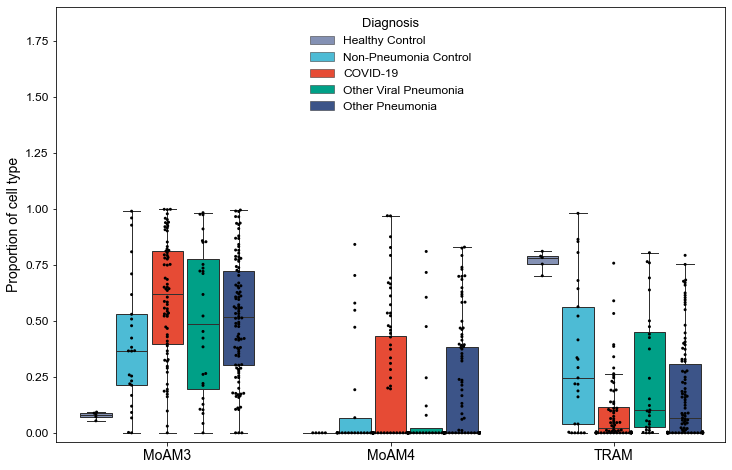

In [55]:
hue_order = ["Healthy Control", "Non-Pneumonia Control", "COVID-19", "Other Viral Pneumonia", "Other Pneumonia"]
fig, ax = plt.subplots(figsize=(12, 8))
sns.boxplot(
    data=props, 
    x="cell_types", 
    y="value", 
    hue="Diagnosis", 
    ax=ax, 
    dodge=True, 
    hue_order=hue_order, 
    palette=ccc,
    saturation=1,
    linewidth=1,
    showfliers=False
)
sns.swarmplot(
    data=props, 
    x="cell_types", 
    y="value", 
    hue="Diagnosis", 
    ax=ax,
    color="black",
    palette=["black"]*5,
    dodge=True,
    hue_order=hue_order,
    size=3
)
ax.set_ylim(-0.04, 1.9)
l = ax.get_legend()
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[:5], labels[:5], title=l.get_title().get_text(), frameon=False, fontsize=12, title_fontsize=13, loc="upper center")
ax.set_ylabel("Proportion of cell type", fontsize=14)
ax.set_xlabel("")
ax.tick_params(axis="x", labelsize=14)
ax.tick_params(axis="y", labelsize=12)
adjust_box_widths(fig, 0.9)

In [56]:
annotations = [f"q={q:.2e}" for q in pvals["adj. p-value"][pvals["adj. p-value"] < 0.05].values]

TRAM_Non-Pneumonia Control v.s. TRAM_COVID-19: Custom statistical test, P_val:2.212e-03
MoAM3_Non-Pneumonia Control v.s. MoAM3_COVID-19: Custom statistical test, P_val:6.659e-03
MoAM3_Healthy Control v.s. MoAM3_Non-Pneumonia Control: Custom statistical test, P_val:1.337e-02
TRAM_Healthy Control v.s. TRAM_Non-Pneumonia Control: Custom statistical test, P_val:2.247e-02
TRAM_COVID-19 v.s. TRAM_Other Viral Pneumonia: Custom statistical test, P_val:4.225e-03
MoAM3_COVID-19 v.s. MoAM3_Other Pneumonia: Custom statistical test, P_val:4.130e-02
MoAM3_Healthy Control v.s. MoAM3_COVID-19: Custom statistical test, P_val:1.719e-03
TRAM_Healthy Control v.s. TRAM_COVID-19: Custom statistical test, P_val:1.392e-03
TRAM_Non-Pneumonia Control v.s. TRAM_Other Pneumonia: Custom statistical test, P_val:2.690e-02
MoAM3_Healthy Control v.s. MoAM3_Other Viral Pneumonia: Custom statistical test, P_val:6.659e-03
TRAM_Healthy Control v.s. TRAM_Other Viral Pneumonia: Custom statistical test, P_val:4.316e-03
TRAM_

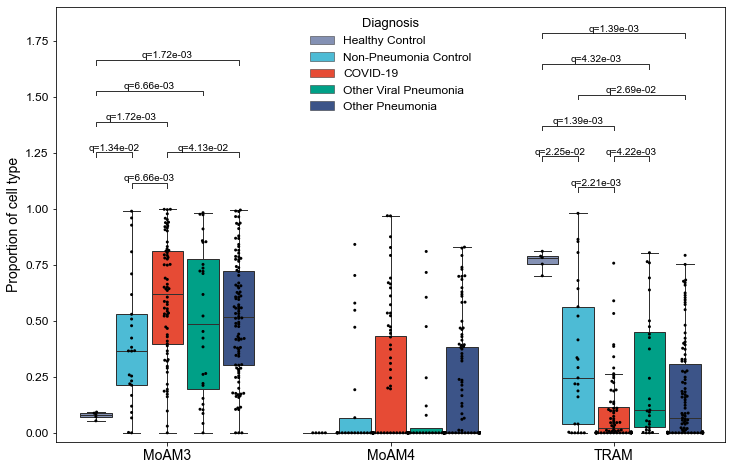

<Figure size 1152x864 with 0 Axes>

In [57]:
test_results = statannot.add_stat_annotation(ax, data=props, x="cell_types", y="value", hue="Diagnosis",
                                   box_pairs=pairs,
                                   hue_order=hue_order,
                                   perform_stat_test=False, 
                                   pvalues=pvals["adj. p-value"][pvals["adj. p-value"] < 0.05].values,
                                     text_annot_custom=annotations,
                                   text_format='full',
                                   test_short_name='',
                                   pvalue_format_string="{:.2e}",
                                   loc='inside', verbose=2, linewidth=1, 
                                    line_offset_to_box=0.05, text_offset=0.01, 
                                    line_offset=0.04, line_height=0.01)
ax.figure

In [58]:
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines['left'].set_bounds((0, 1))

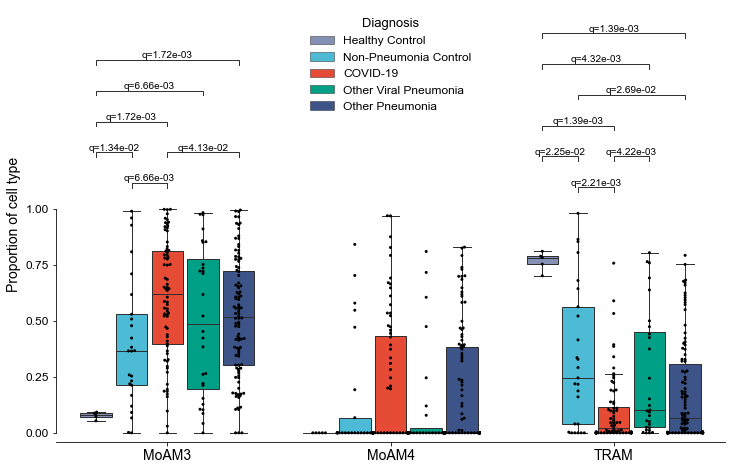

In [59]:
yticks = ax.get_yticks()
yticks= yticks[(yticks >= 0) & (yticks <= 1.01)]
ax.set_yticks(yticks)
fig

In [60]:
fig.tight_layout()
fig.savefig("07plots/S5C_deconvolution_v2.pdf")